In [1]:
from PIL import Image
import numpy as np
import random
import time
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import os
import glob

## 1 Generate a Test Map

draw a simplified pixel map on https://www.pixilart.com/draw?ref=home-page#

In [2]:
# read a pixel map with marked intersection
mapname = 'default_map_0.png'
image = Image.open(mapname)

In [3]:
intersectionMap = np.asarray(image).T[0].T
laneMap = np.asarray(image).T[-1].T
map = np.where(intersectionMap==0, intersectionMap, 1) + np.where(laneMap==0, intersectionMap, 1)

In [4]:
# img = Image.fromarray(map*127,"L")

## Animation Helper
not important

In [118]:
class Animator():
    """初始化横轴,x/ylabel,"""
    def __init__(self, xlim, xlabel=None, ylabel=None, legend=None,ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'),figsize=(3.5, 2.5),dirname=None) -> None:
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xscale = xscale
        self.yscale = yscale
        self.xlim = xlim
        self.ylim = ylim
        self.legend = legend
        # 图例显示
        if legend is None:
            legend = []
        # 使用svg图像显示
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(figsize=figsize)
        self.x = None
        self.y = None
        self.fmts = fmts
        self.dirname = dirname

    def set_axes(self):
        # 设置轴上的属性
        self.axes.set_xlabel(self.xlabel)
        self.axes.set_ylabel(self.ylabel)
        self.axes.set_xscale(self.xscale)
        self.axes.set_yscale(self.yscale)
        self.axes.set_xlim(self.xlim)
        self.axes.set_ylim(self.ylim)
        if self.legend:
            self.axes.legend(self.legend)
        self.axes.grid()


    def show(self,x,y):
        self.axes.cla()
        #intersection
        self.axes.scatter(x[2],y[2], linewidth=2.5,c="green", zorder=2.5)
        self.axes.scatter(x[3],y[3], linewidth=2.5,c="orange", zorder=3)
        #current position
        self.axes.scatter(x[1],y[1], linewidth=2.5, zorder=3.5)
        #trace
        self.axes.plot(x[0],y[0], self.fmts[0], linewidth=2.5)
        self.set_axes()
        if self.dirname:
            plt.savefig('%s/%s.png'%(self.dirname,time.time()))
        display.display(self.fig)
        display.clear_output(wait=True)

In [136]:
def draw(fig, point, point2, point3,x,y):
    print(point)
    x[0].append(point[0])
    y[0].append(point[1])

    x[1]=[point[0]]
    y[1]=[point[1]]

    x[2] = []
    y[2] = []
    x[3] = []
    y[3] = []

    for p in point2 :
        if p not in point3:
            x[2].append(p[0])
            y[2].append(p[1])
    
    for p in point3:
        x[3].append(p[0])
        y[3].append(p[1])

    fig.show(y,x)
    time.sleep(0.1)

## 2 Pseudo

In [106]:
def isLane(point):
    x,y = point
    if 0 <= x <= map.shape[0]-1 and 0 <= y <= map.shape[1]-1 :
        if map[x][y] == 1:
            return True
    return False

def isIntersection(point):
    x,y = point
    if 0 <= x <= map.shape[0]-1 and 0 <= y <= map.shape[1]-1 :
        if map[x][y] == 2:
            return True
    return False


def initialStartpoint():
    while True:
        x = random.randint(0,map.shape[0]-1)
        y = random.randint(0,map.shape[1]-1)
        if isLane((x,y)):
            break
    return (x,y)

def initialStartdirection(startPoint):
    directions =  [(0,-1),(0,1),(-1,0),(1,0)]
    while True:
        i = random.randint(0,3)
        x = startPoint[0]+directions[i][0]
        y = startPoint[1]+directions[i][1]
        # if out of range, change to the next direction
        if isLane((x,y)) or isIntersection((x,y)):
            break
    return (x,y)


In [110]:
def driveOneStepForward(currentPoint, nextPoint):
    # stop by intersection
    if isIntersection(nextPoint):
        return (currentPoint, nextPoint, True)
    else:
        # find the next direction
        directions =  [(0,-1),(0,1),(-1,0),(1,0)]
        lastpoint = currentPoint
        currentPoint = nextPoint
        for (x,y) in directions:
            nextPoint = (currentPoint[0]+x,currentPoint[1]+y)
            if nextPoint != lastpoint:
                if isLane(nextPoint) or isIntersection(nextPoint):
                    return (currentPoint, nextPoint, False)
        # if dead end, go back
        return (currentPoint, lastpoint, isIntersection(lastpoint))

def driveForward(currentPoint, nextPoint):
    isIntersection = False
    while not isIntersection:
        (currentPoint, nextPoint, isIntersection) = driveOneStepForward(currentPoint, nextPoint)
    return (currentPoint, nextPoint, True)
                
def driveTurnLeft(currentPoint, nextPoint):
    # if not intersection cannot turn left
    if not isIntersection(nextPoint):
        return (currentPoint, nextPoint, False)
    else:
        lastpoint = currentPoint
        currentPoint = nextPoint # go into the intersection
        while True:
            originalDirection = np.matrix([currentPoint[0]-lastpoint[0],currentPoint[1]-lastpoint[1]])
            turnLeftMat = np.matrix([[0,1],[-1,0]])
            newDirection = originalDirection*turnLeftMat
            x = np.asarray(newDirection)[0][0]
            y = np.asarray(newDirection)[0][1]
            nextPoint = (currentPoint[0]+x,currentPoint[1]+y)
            if isLane(nextPoint):
                return (currentPoint, nextPoint, False)
            else:
                lastpoint = nextPoint

In [9]:
def getIntersectionExits(intersection):
    exits = []
    for (x,y) in [(0,-1),(0,1),(-1,0),(1,0)]:
        nextPoint = (intersection[0]+x,intersection[1]+y)
        if isLane(nextPoint) or isIntersection(nextPoint):
            exits.append(nextPoint)
    return exits

In [134]:
def initialMap(currentPosition, nextPosition, fig):
    # for drawing
    x = [[],[],[],[]]
    y = [[],[],[],[]]

    intersectionSet = {}
    unfinishedIntersections = []
    mappingStared = False
    lastIntersection = None

    # draw start step
    draw(fig, currentPosition,intersectionSet, unfinishedIntersections, x,y)

    # drive until all intersections are finished
    while True:
        if mappingStared and unfinishedIntersections == []:
            return intersectionSet
            break

        # drive one step for drawing, otherwise can directly drive until an intersection
        #(currentPosition, nextPosition, isIntersection_) = driveForward(currentPosition, nextPosition)
        (currentPosition, nextPosition, isIntersection_) = driveOneStepForward(currentPosition, nextPosition)
        # draw each step
        draw(fig, currentPosition,intersectionSet, unfinishedIntersections, x, y) 

        # if nextposition is an intersection
        if isIntersection_:
            mappingStared = True

            currentIntersection = nextPosition
            # get all exits (to check if this intersection is done)
            exits = getIntersectionExits(currentIntersection)

            # if the intersection is new
            if currentIntersection not in intersectionSet:
                # initial intersection structure
                intersectionSet[currentIntersection] = {"exits":{}, "connections":{} }  # neigbouts = exits->connections

                # mark the new intersection as unfished
                unfinishedIntersections.append(currentIntersection)

                # mark connections between the current exit(entrance) and the  last intersection
                if lastIntersection != None:
                    intersectionSet[currentIntersection]["connections"][currentPosition] = lastIntersection
                lastIntersection = currentIntersection
                
                # initial all unvisited exits
                for exit in exits:
                    intersectionSet[currentIntersection]["exits"][exit]=False
                    # but mark the current exit(entrance) as visited
                    intersectionSet[currentIntersection]["exits"][currentPosition]=True

                # turn left
                (currentPosition, nextPosition, isIntersection_) = driveTurnLeft(currentPosition, currentIntersection)
                # and mark this exit as visited
                intersectionSet[currentIntersection]["exits"][nextPosition]=True
            
            # if we got here once before
            else:
                # mark connections between the current exit(entrance) and the  last intersection
                intersectionSet[currentIntersection]["connections"][currentPosition] = lastIntersection

                # mark the current exit(entrance) as visited
                intersectionSet[currentIntersection]["exits"][currentPosition]=True

                ## update visited/unvisited and finished/unfinished
                # check all exits if they are all visited
                for exit in intersectionSet[currentIntersection]["exits"]:
                    if intersectionSet[currentIntersection]["exits"][exit]:
                        exits.remove(exit)

                # if there are still unvisited exits
                if exits != []:
                    # goto this exit
                    nextPosition = exits[0]
                    currentPosition = currentIntersection
                    # mark this exit as visited
                    intersectionSet[currentIntersection]["exits"][nextPosition]=True
                    exits.remove(nextPosition)
                    if exits == []:
                        if currentIntersection in unfinishedIntersections:
                            unfinishedIntersections.remove(currentIntersection)
                
                # if all exits are visited (cannot be else, because the last step may delte an exit)
                else:
                    if currentIntersection in unfinishedIntersections:
                        unfinishedIntersections.remove(currentIntersection)
                    # TODO: choose an exit which has connection to a unfinished Intersection
                    # current: choose the left exit
                    (currentPosition, nextPosition, isIntersection_) = driveTurnLeft(currentPosition, currentIntersection)
        
            draw(fig, currentPosition,intersectionSet, unfinishedIntersections, x, y)


## Run for an example

In [77]:
startPoint = initialStartpoint()
startDirection = initialStartdirection(startPoint)
print("current position:\t%s\nnext position:\t\t%s"%(startPoint, startDirection))

current position:	(5, 7)
next position:		(5, 8)


In [78]:
dirname = time.time()
os.makedirs("img/%s"%dirname)

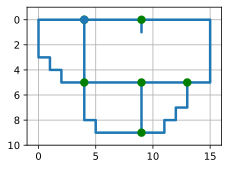

In [135]:
fig = Animator(xlim=(-1,map.shape[1]),ylim=(map.shape[0],-1),dirname="img/%s"%dirname)
intersections = initialMap(startPoint, startDirection, fig)

In [121]:
search_dir = "img/%s/"%dirname
# remove anything from the list that is not a file (directories, symlinks)
# thanks to J.F. Sebastion for pointing out that the requirement was a list 
# of files (presumably not including directories)  
files = list(filter(os.path.isfile, glob.glob(search_dir + "*")))
files.sort(key=lambda x: os.path.getmtime(x))

frames = [Image.open(image) for image in files]
frame_one = frames[0]
frame_one.save("test/%s.gif"%dirname, format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

In [137]:
intersections

{(5, 9): {'exits': {(5, 8): True, (5, 10): True, (6, 9): True},
  'connections': {(5, 8): (5, 4), (5, 10): (9, 9)}},
 (5, 13): {'exits': {(5, 12): True, (5, 14): True, (6, 13): True},
  'connections': {(5, 12): (5, 9), (6, 13): (9, 9)}},
 (0, 9): {'exits': {(0, 8): True, (0, 10): True, (1, 9): True},
  'connections': {(0, 10): (5, 13), (1, 9): (0, 9)}},
 (0, 4): {'exits': {(0, 3): True, (0, 5): True, (1, 4): True},
  'connections': {(0, 5): (0, 9), (0, 3): (9, 9)}},
 (5, 4): {'exits': {(5, 3): True, (4, 4): True, (5, 5): True, (6, 4): True},
  'connections': {(4, 4): (0, 4), (6, 4): (9, 9)}},
 (9, 9): {'exits': {(9, 8): True, (8, 9): True, (9, 10): True},
  'connections': {(8, 9): (9, 9)}}}

In [138]:
# TODO: connections seem not correct
# TODO: if an intersection is finished, and the car comes to it again, choose a better eixt than turn left